# Unsupervised Machine Learning for the Classification of Astrophysical X-ray Sources
###### *Víctor Samuel Pérez Díaz<sup>1</sup>, Rafael Martinez-Galarza<sup>2</sup>, Alexander Caicedo-Dorado<sup>1</sup>, Raffaele D'Abrusco<sup>2</sup>*

*1. Universidad del Rosario, 2. Center for Astrophysics | Harvard & Smithsonian*

---

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import mixture
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from astropy import stats
from astropy.io.votable import parse
from scipy.spatial.distance import cdist

from mpl_toolkits.mplot3d import Axes3D

import itertools

%matplotlib inline

In [2]:
def votable_to_pandas(votable_file):
    '''
    Converts votable to pandas dataframe.
    '''
    votable = parse(votable_file)
    table = votable.get_first_table().to_table(use_names_over_ids=True)
    return table.to_pandas()

In [3]:
data = pd.read_csv("./data/optixray_finally_samuelperezdi.csv")

In [9]:
data['u-g'] = data.u - data.g
data['g-r'] = data.g - data.r
data['r-i'] = data.r - data.i
data['i-z'] = data.i - data.z

In [10]:
data

,name,obsid,region_id,theta,ra,dec,significance,likelihood,src_area_b,flux_aper_b,...,specobjid,class,redshift,plate,mjd,fiberid,u-g,g-r,r-i,i-z
0,2CXO J132106.3+003714,4824,5,2.119055,200.2764,0.620611,17.28654,2010.7030,NaN,1.297852e-13,...,null,NaN,NaN,NaN,NaN,NaN,0.49465,0.10559,-0.08290,0.16863
1,2CXO J144214.1+005741,3960,16,14.473190,220.5588,0.961449,10.45455,330.4539,110.202600,2.236891e-13,...,345820898969806848,QSO,0.603458,307.0,51663.0,617.0,0.40780,-0.08110,0.15029,-0.04074
2,2CXO J144309.2+010213,3960,58,12.804500,220.7885,1.037038,14.38368,513.7379,1072.689000,3.342333e-13,...,603485132803827712,GALAXY,0.528579,536.0,52024.0,10.0,3.71375,1.70979,1.02065,0.52461
3,2CXO J100247.0+002103,13976,50,16.001190,150.6959,0.350901,11.12087,299.4449,59.000760,5.985373e-14,...,302973209857255424,QSO,2.167938,269.0,51910.0,386.0,0.22440,0.06364,0.09358,0.17642
4,2CXO J100255.7+001840,13976,61,13.000440,150.7321,0.311191,13.56834,431.4743,33.085830,3.672572e-14,...,null,NaN,NaN,NaN,NaN,NaN,-0.25335,1.07879,1.12709,1.03158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4080,2CXO J233831.6+270035,4816,8,1.901208,354.6320,27.009780,15.46088,1421.1270,NaN,4.751777e-14,...,null,NaN,NaN,NaN,NaN,NaN,0.23900,0.04580,0.26853,-0.13897
4081,2CXO J224510.3+263342,3287,8,2.287855,341.2933,26.561810,11.92267,1029.2860,0.058270,1.908682e-13,...,7088696429267361792,GALAXY,0.542854,6296.0,56219.0,111.0,1.36765,1.54735,1.23867,0.51091
4082,2CXO J222653.0+255134,12249,14,1.968493,336.7212,25.859460,16.44176,1718.4050,0.000483,1.442847e-13,...,null,NaN,NaN,NaN,NaN,NaN,0.21229,0.58776,0.55298,0.39380
4083,2CXO J222631.4+255213,12249,16,4.702007,336.6310,25.870380,11.84068,752.7114,1.523609,7.837906e-14,...,null,NaN,NaN,NaN,NaN,NaN,0.90565,0.45995,0.35079,0.30809


In [ ]:
# features_out = ['name', 'ra', 'dec', 'theta', 'src_area_b', 'flux_aper_b', 
#                 'hard_hm', 'hard_hs',
#                'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b', 'var_sigma_b',
#                'var_mean_b', 'var_min_b', 'var_max_b', 'var_prob_h', 'var_sigma_h',
#                'var_mean_h', 'var_min_h', 'var_max_h', 'var_prob_m', 'var_sigma_m',
#                'var_mean_m', 'var_min_m', 'var_max_m', 'var_prob_s', 'var_sigma_s',
#                'var_mean_s', 'var_min_s', 'var_max_s', 'ks_prob_b', 'ks_prob_h',
#                'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m',
#                'kp_prob_s']

features = ['theta', 'src_area_b', 'hard_hm', 'hard_hs', 'hard_ms', 'powlaw_gamma', 'bb_kt', 'var_prob_b','var_sigma_b', 'var_mean_b', 'var_min_b', 'var_max_b', 'var_prob_h', 'var_sigma_h', 'var_mean_h', 'var_min_h', 'var_max_h', 'var_prob_m', 'var_sigma_m', 'var_mean_m', 'var_min_m', 'var_max_m', 'var_prob_s', 'var_sigma_s',
'var_mean_s', 'var_min_s', 'var_max_s', 'ks_prob_b', 'ks_prob_h', 'ks_prob_m', 'ks_prob_s', 'kp_prob_b', 'kp_prob_h', 'kp_prob_m', 'kp_prob_s' , 'u-g', 'g-r', 'r-i', 'i-z']

features_lognorm = ['theta', 'src_area_b', 'bb_kt', 'var_sigma_b', 'var_mean_b', 'var_min_b', 'var_max_b', 'var_sigma_h', 'var_mean_h', 'var_min_h', 'var_max_h', 'var_sigma_m', 'var_mean_m', 'var_min_m', 'var_max_m',  'var_sigma_s', 'var_mean_s', 'var_min_s', 'var_max_s']

features_norm = ['powlaw_gamma', 'u-g', 'g-r', 'r-i', 'i-z']

X_df_out = data.dropna(subset=features)
X_df = X_df_out[features]
X = X_df.copy(deep=True).to_numpy()

In [2]:
len(features)

39

In [44]:
percent_missing = data[features].isnull().sum() * 100 / len(data[features])
missing_value_df = pd.DataFrame({'column_name': data[features].columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', inplace=True)
missing_value_df

,column_name,percent_missing
theta,theta,0.000000
g-r,g-r,0.000000
u-g,u-g,0.000000
r-i,r-i,0.000000
bb_kt,bb_kt,0.000000
i-z,i-z,0.000000
powlaw_gamma,powlaw_gamma,0.000000
hard_hm,hard_hm,0.611995
hard_hs,hard_hs,0.709914
var_prob_b,var_prob_b,0.734394


## Applying log transform and normalizing.

In [12]:
# FUNCTION lognorm
# Apply log transform adding the minimum non-zero value divided by ten in order to preserve zero properties, then normalize.
# INPUT:
# X_df = data array
# X = data array as np array
# name_desc = string, name of the descriptor
# log = boolean, True if apply log transform before norm

# PROCEDURE:
# Modifies X np array of data with the normalizated data
def lognorm(X_df, X, name_desc, log):
    
    col = X_df.columns.get_loc(name_desc)
    X_desc = X_df[name_desc]
    
    if log:
        nonzero = X_desc[X_desc!=0]
        minval = np.min(nonzero)/10

        # print(minval)
        X_desc = X_desc + minval

        x = np.log(X_desc.values)  #returns a numpy array
    else:
        x = X_desc.to_numpy()
    min_max_scaler = MinMaxScaler(feature_range=(0,1))
    x_scaled = min_max_scaler.fit_transform(x.reshape(-1,1))
    X[:,col] = x_scaled.flatten()
    
    return X

In [13]:
# Log transformation

for feature in features_lognorm:
    X = lognorm(X_df, X, feature, True)
        
for feature in features_norm:
    X = lognorm(X_df, X, feature, False)

In [14]:
X_df = pd.DataFrame(X, columns=X_df.columns)
X = X_df.to_numpy()

In [15]:
X.shape

(2841, 39)

In [22]:
X_df

,theta,src_area_b,hard_hm,hard_hs,hard_ms,powlaw_gamma,bb_kt,var_prob_b,var_sigma_b,var_mean_b,...,ks_prob_m,ks_prob_s,kp_prob_b,kp_prob_h,kp_prob_m,kp_prob_s,u-g,g-r,r-i,i-z
0,0.920782,0.710159,0.018738,-0.402249,-0.414741,0.442357,0.101458,0.162399,0.740384,0.337473,...,0.781165,0.781764,0.757351,0.120957,0.894062,0.650166,0.131044,0.099470,0.585298,0.412468
1,0.902287,0.836560,0.034978,-0.227358,-0.258588,0.411463,0.211229,0.156943,0.752029,0.402216,...,0.738395,0.860850,0.977919,0.214136,0.701640,0.930752,0.358791,0.396206,0.787738,0.491039
2,0.904580,0.643325,-0.024984,-0.027483,-0.003748,0.457970,0.198732,0.000221,0.536579,0.233770,...,0.293347,0.353969,0.154052,0.238773,0.358981,0.068984,0.085498,0.291654,0.812495,0.561498
3,0.827070,0.630766,0.133666,-0.036227,-0.169894,0.384336,0.236397,0.145249,0.699296,0.067116,...,0.497971,0.324689,0.061022,0.300255,0.439501,0.106793,0.146112,0.150902,0.583284,0.446743
4,0.785410,0.484369,-0.046221,-0.072455,-0.024984,0.444845,0.194777,0.172705,0.698932,0.040566,...,0.021210,0.263903,0.257170,0.162570,0.010461,0.285451,0.117941,0.245764,0.665794,0.512844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2836,0.434750,0.412805,-0.099938,-0.570893,-0.499688,0.504448,0.115691,0.032213,0.657145,0.318873,...,0.323849,0.866088,0.700818,0.359676,0.086783,0.888313,0.244565,0.264759,0.662172,0.467459
2837,0.642384,0.291091,0.708307,0.914428,0.578388,0.423007,0.324247,0.065542,0.693886,0.268516,...,0.629344,0.269571,0.234114,0.269266,0.271537,0.566393,0.197168,0.369291,0.838448,0.489135
2838,0.619712,0.027934,-0.217364,-0.545909,-0.372267,0.484306,0.151398,0.401154,0.748377,0.286721,...,0.397851,0.542997,0.873415,0.887108,0.205628,0.815581,0.117576,0.210294,0.678961,0.472859
2839,0.751067,0.472354,-0.019988,0.172392,0.191131,0.448493,0.238132,0.222026,0.719559,0.212011,...,0.829615,0.816419,0.886035,0.957961,0.647360,0.831394,0.165341,0.189117,0.631933,0.460948


***Note 2***

In [16]:
gm = GaussianMixture(n_components=6, covariance_type = 'full', random_state=0).fit(X)

C = gm.means_
# Predicting the clusters
labels = gm.predict(X)

In [33]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
 
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

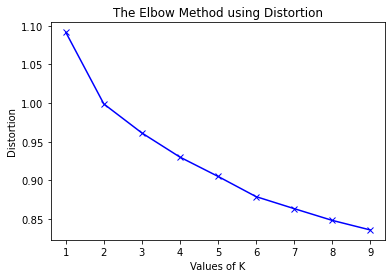

In [34]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

[Text(0.5, 0, 'src_area_b')]

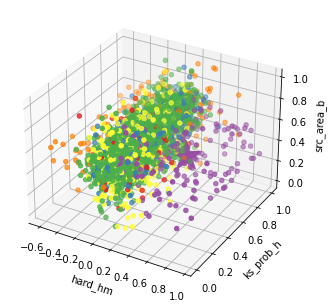

In [19]:
# %matplotlib notebook

colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("ks_prob_h")
colz = X_df.columns.get_loc("src_area_b")

colores=['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33'] # 6
markers=["o", "v", "1", "s", "X", "P"]
asignar=[]
for row in labels:
    asignar.append(colores[row])
    
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, colx], X[:, coly], X[:, colz], c=asignar,s=20)
ax.scatter(C[:, colx], C[:, coly], C[:, colz], marker='*', c=colores, s=1000)
ax.set(xlabel = X_df.columns[colx])
ax.set(ylabel = X_df.columns[coly])
ax.set(zlabel = X_df.columns[colz])

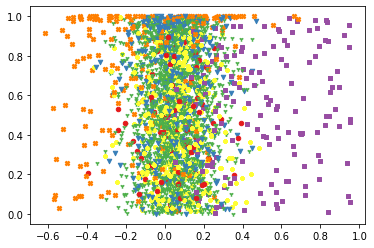

In [20]:
fig = plt.figure()
for i, row in enumerate(labels):
    plt.scatter(X[i, colx], X[i, coly], color=colores[row], marker=markers[row], s=20)
plt.show()

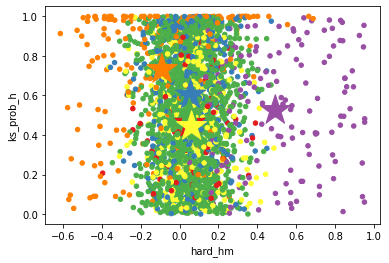

In [23]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("ks_prob_h")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

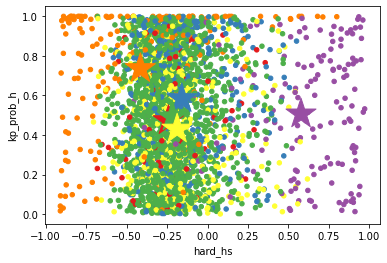

In [24]:
colx = X_df.columns.get_loc("hard_hs")
coly = X_df.columns.get_loc("kp_prob_h")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

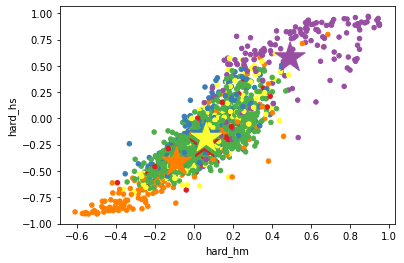

In [25]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("hard_hs")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

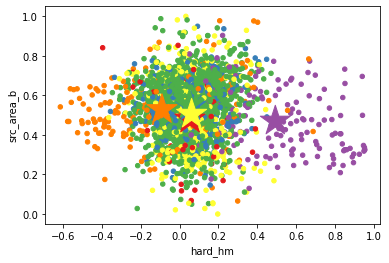

In [26]:
colx = X_df.columns.get_loc("hard_hm")
coly = X_df.columns.get_loc("src_area_b")
fig = plt.figure()
plt.scatter(X[:, colx], X[:, coly], c=asignar,s=20)
plt.scatter(C[:, colx], C[:, coly], marker='*', c=colores, s=1000)
plt.xlabel(X_df.columns[colx]);
plt.ylabel(X_df.columns[coly]);

In [27]:
X_df_out_final = X_df_out.copy(deep=True)
X_df_out_final['cluster'] = labels

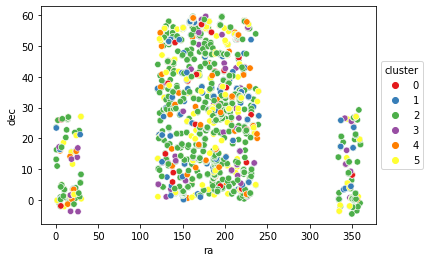

In [28]:
X_np_out=X_df_out_final.to_numpy()
colors = sns.color_palette()[0:6]

colx = X_df_out_final.columns.get_loc("ra")
coly = X_df_out_final.columns.get_loc("dec")
fig = plt.figure()
s = sns.scatterplot(data=X_df_out_final, x='ra', y='dec', hue=X_df_out_final["cluster"], palette=colores, s=40);
s.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, title='cluster')
plt.xlabel(X_df_out_final.columns[colx]);
plt.ylabel(X_df_out_final.columns[coly]);
plt.show()

In [29]:
X_df_out_final.to_csv('cluster_data/clusterized_optixray_colors.csv')